In [184]:
import pandas as pd
import yfinance as yf
from datetime import date, timedelta
import plotly.graph_objects as go
import plotly.express as px
from matplotlib import pyplot as plt
import talib as ta
import numpy as np

In [185]:
import plotly.io as pio

pio.templates.default = "plotly_dark"

In [186]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


## Load and explore stocks

In [187]:
stock = "AMZN"

In [188]:
today = date.today()

d1 = today.strftime("%Y-%m-%d")
end_date = d1
d2 = date.today() - timedelta(days=365)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2
# Here he use the download method but we could also just use the ticker
stock_hist = yf.download(f"{stock}", start=start_date, end=end_date, progress=False)

### Multiple visualisations of our dataset

In [189]:
fig = go.Figure(
    data=[
        go.Candlestick(
            x=stock_hist.index,
            open=stock_hist["Open"],
            high=stock_hist["High"],
            low=stock_hist["Low"],
            close=stock_hist["Close"],
        )
    ]
)
fig.update_layout(title=f"{stock} chart from {start_date} to {end_date}")

fig.show()

In [190]:
fig = px.line(
    stock_hist,
    x=stock_hist.index,
    y="Close",
    title=f"{stock} Analysis with Rangeslider",
)
fig.update_layout(xaxis_rangeslider_visible=True)

Text(0.5, 1.0, 'Barplot of AMZN')

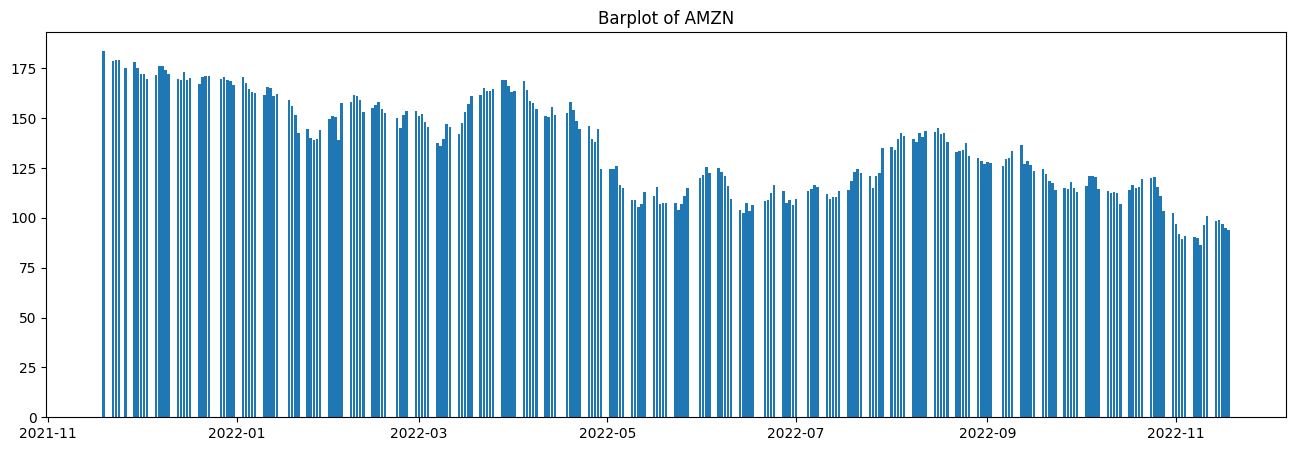

In [206]:
fig = plt.figure(figsize=(16, 5))
plt.bar(x=stock_hist.index, height=stock_hist["Close"])
plt.title(f"Barplot of {stock}")

#### Moving average

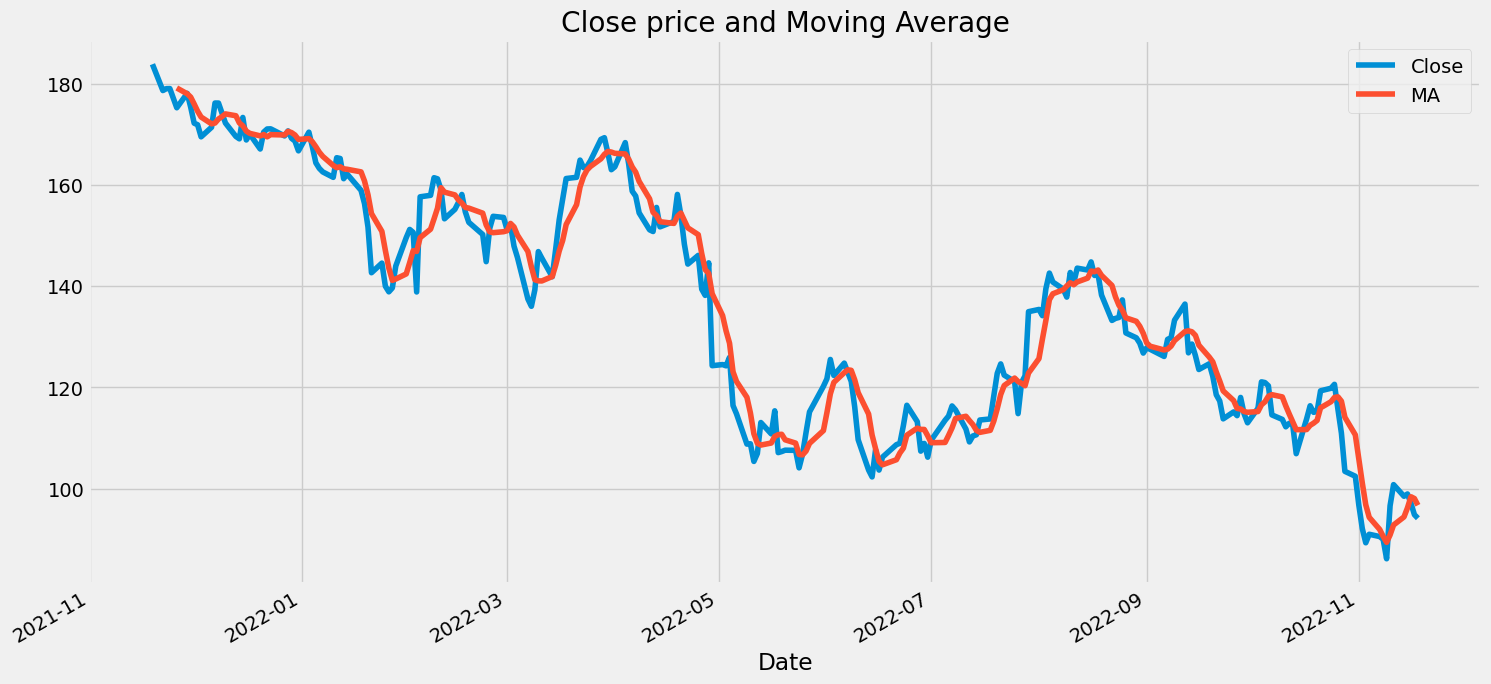

In [192]:
plt.style.use("fivethirtyeight")
stock_hist["MA"] = ta.SMA(stock_hist["Close"], timeperiod=5)
stock_hist[["Close", "MA"]].plot(
    figsize=(16, 8), title="Close price and Moving Average"
)
plt.show()

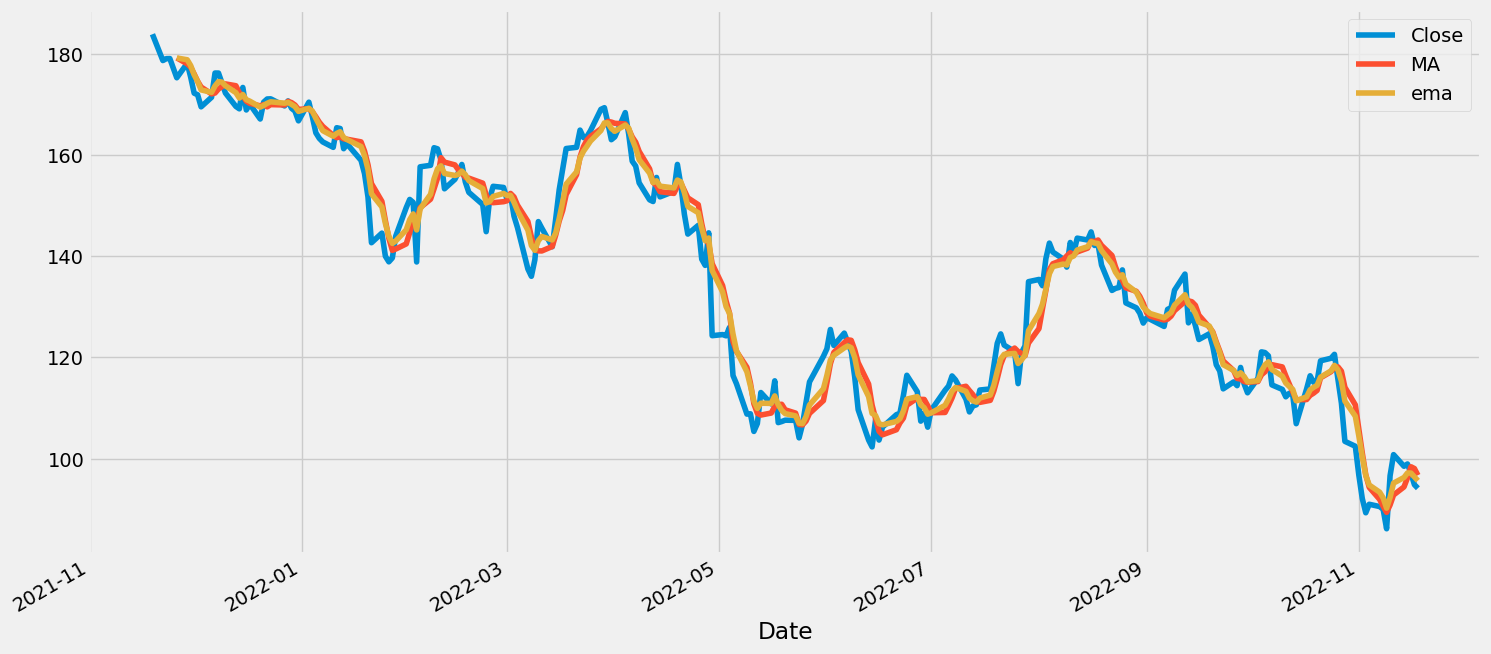

In [193]:
plt.style.use("fivethirtyeight")
stock_hist["ema"] = ta.EMA(stock_hist["Close"], timeperiod=5)
stock_hist[["Close", "MA", "ema"]].plot(figsize=(16, 8))
plt.show()

### RSI

What is Relative Strength Index(RSI)
RSI is a momentum indicator that helps to learn whether a certain share is overbought or oversold. Its value lies between 0-100. If it is under 30, it means it is oversold and has a chance to buy it. If the value lies above 70, it means it is overbought and it is a good chance to dump your stock. Let’s calculate and chart the RSI of the FB/Meta stock. Let’s check the RSI of FB.

In [194]:
stock_hist["RSI"] = ta.RSI(stock_hist["Close"])

<AxesSubplot: xlabel='Date'>

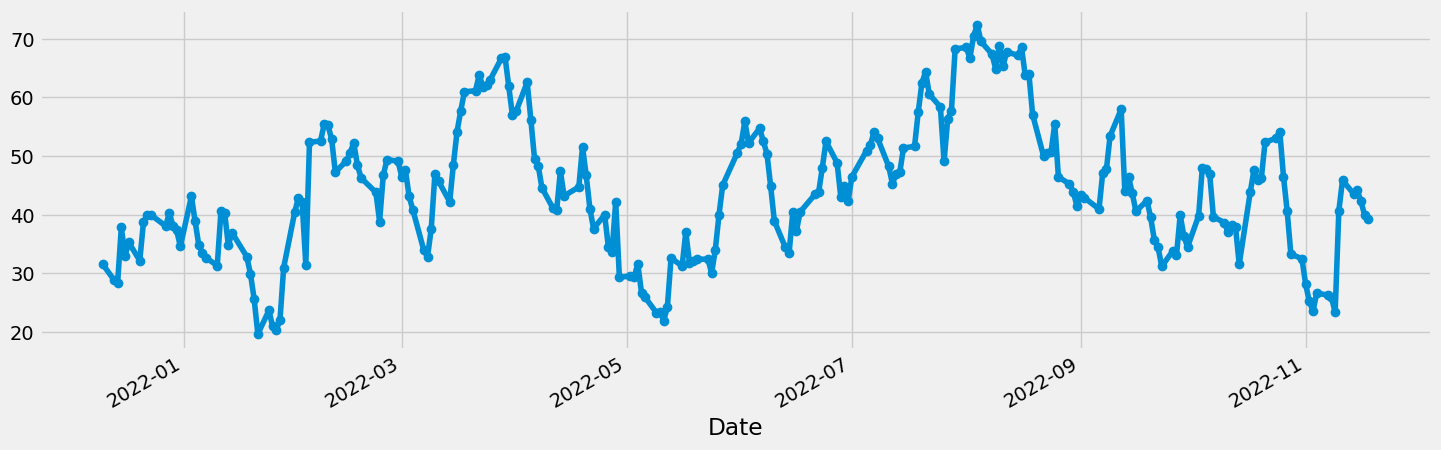

In [195]:
stock_hist["RSI"].plot(figsize=(16, 5), marker="o")

Text(0.5, 1.0, 'Relative strength index')

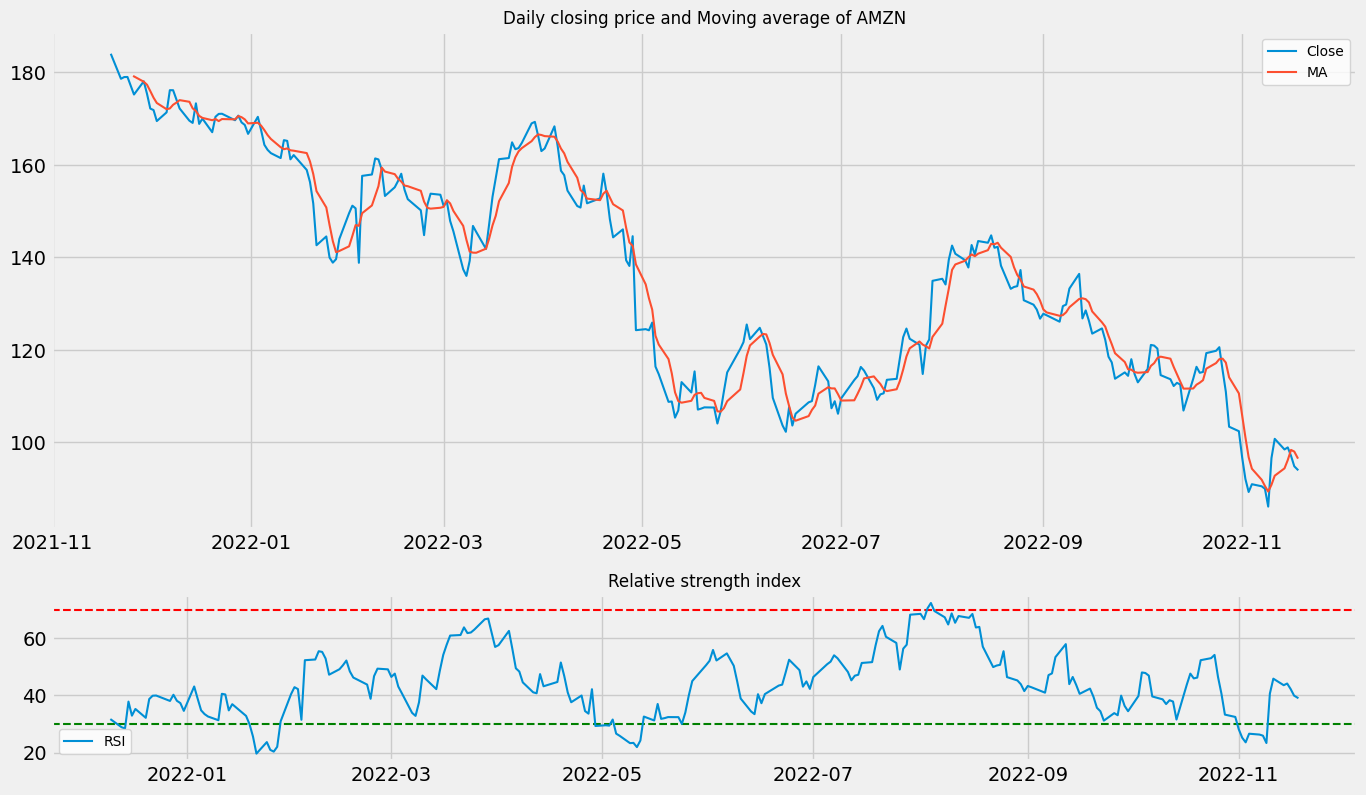

In [196]:
fig, axs = plt.subplots(2, 1, gridspec_kw={"height_ratios": [3, 1]}, figsize=(15, 9))
plt.style.use("default")
# axs[0].plot(stock_hist[['Close',"MA"]], label=["Close", "MA"])
axs[0].plot(stock_hist["Close"], label="Close")
axs[0].plot(stock_hist["MA"], label="MA")
axs[0].legend(loc="best")
axs[1].axhline(y=70, color="r", linestyle="--")
axs[1].axhline(y=30, color="g", linestyle="--")
axs[1].plot(stock_hist["RSI"], label="RSI")
axs[1].legend(loc="best")
axs[0].set_title(f"Daily closing price and Moving average of {stock}")
axs[1].set_title(f"Relative strength index")

In [197]:
timeperiod = 100
stock_hist["LinearReg"] = ta.LINEARREG(stock_hist["Close"], timeperiod=timeperiod)

Text(0.5, 1.0, 'Linear regression for 100 days')

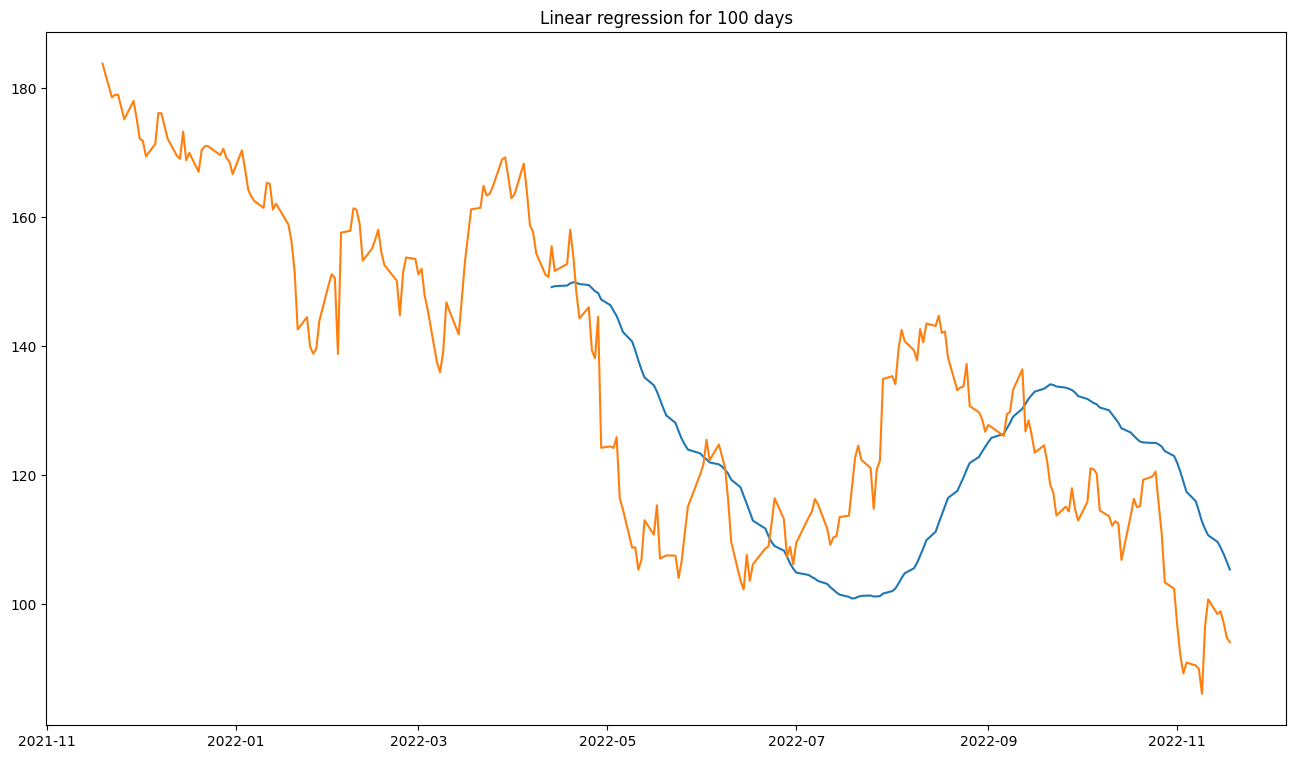

In [198]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(stock_hist["LinearReg"])
ax.plot(stock_hist["Close"])
ax.set_title(f"Linear regression for {timeperiod} days")

When the MACD is above MACD signal you buy

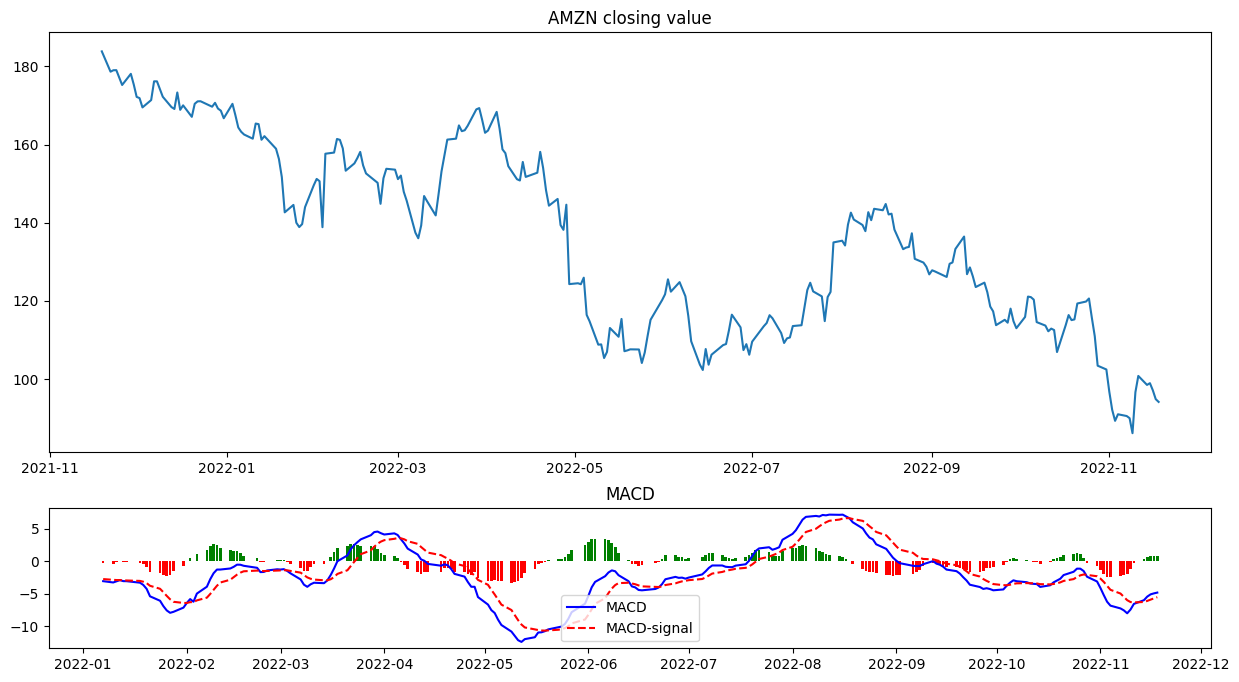

In [199]:
macd, macd_signal, macd_hist = ta.MACD(stock_hist["Close"])
fig, ax = plt.subplots(2, 1, gridspec_kw={"height_ratios": [3, 1]}, figsize=(15, 8))

color = ["red" if cl < 0 else "green" for cl in macd_hist]

ax[0].plot(stock_hist["Close"])
ax[0].set_title(f"{stock} closing value")
ax[1].plot(macd, "b-", label="MACD")
ax[1].plot(macd_signal, "--", color="red", label="MACD-signal")
ax[1].bar(macd_hist.index, macd_hist, color=color)
ax[1].set_title("MACD")
ax[1].legend(loc="best")
# fig.legend(loc="lower right")

### Bollinger Bands

In [200]:
stock_hist["SMA"] = stock_hist["Close"].rolling(window=20).mean()
stock_hist["stdev"] = stock_hist["Close"].rolling(window=20).std()
stock_hist["Upper"] = stock_hist["SMA"] + 2 * stock_hist["stdev"]
stock_hist["Lower"] = stock_hist["SMA"] - 2 * stock_hist["stdev"]

Identify buying signals

In [201]:
stock_hist["buy_signal"] = np.where(
    stock_hist["Lower"] > stock_hist["Close"], True, False
)
stock_hist["sell_signal"] = np.where(
    stock_hist["Upper"] < stock_hist["Close"], True, False
)

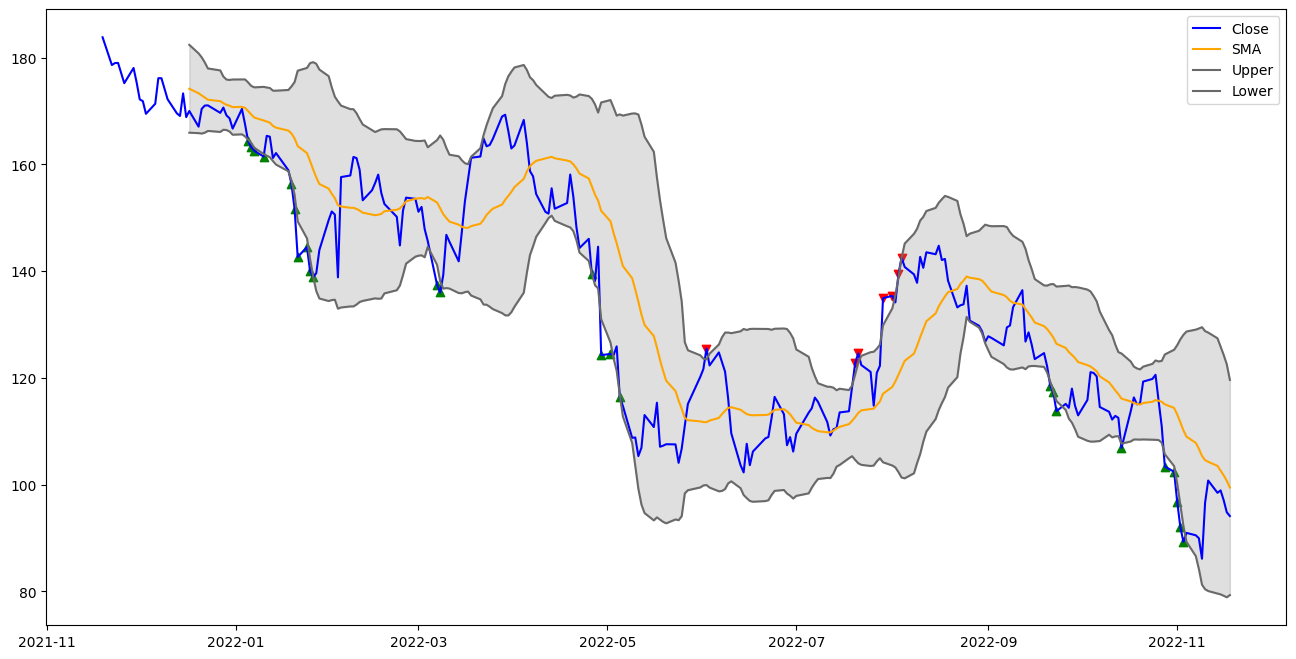

In [202]:
fig, ax = plt.subplots(figsize=(16, 8))
colors = ["blue", "orange", "dimgray", "dimgray"]
ax.set_prop_cycle("color", colors)
h = ax.plot(
    stock_hist[["Close", "SMA", "Upper", "Lower"]],
)
# Find the buying points when the buying signal is true
ax.scatter(
    stock_hist[stock_hist["buy_signal"]].index,
    stock_hist[stock_hist["buy_signal"]]["Close"],
    marker="^",
    color="g",
)
ax.scatter(
    stock_hist[stock_hist["sell_signal"]].index,
    stock_hist[stock_hist["sell_signal"]]["Close"],
    marker="v",
    color="r",
)
ax.fill_between(
    stock_hist.index, stock_hist["Upper"], stock_hist["Lower"], color="grey", alpha=0.25
)
# for line, color in zip(h, colors):
#     line.set_color(color)
ax.legend(["Close", "SMA", "Upper", "Lower"])

In [203]:
# Checking trades with Bollinger bands
buys = []
sells = []
position = "Closed"

for i in range(len(stock_hist)):
    if stock_hist["Lower"][i] > stock_hist["Close"][i]:
        if position == "Closed":
            buys.append(i)
            position = "Open"
    elif stock_hist["Upper"][i] < stock_hist["Close"][i]:
        if position == "Open":
            sells.append(i)
            position = "Closed"

In [204]:
print(f"Your buy ocassions:{buys}")
print(f"Your sell ocassions:{sells}")

Your buy ocassions:[31, 209]
Your sell ocassions:[133]


### Plot the buy and sell ocassions

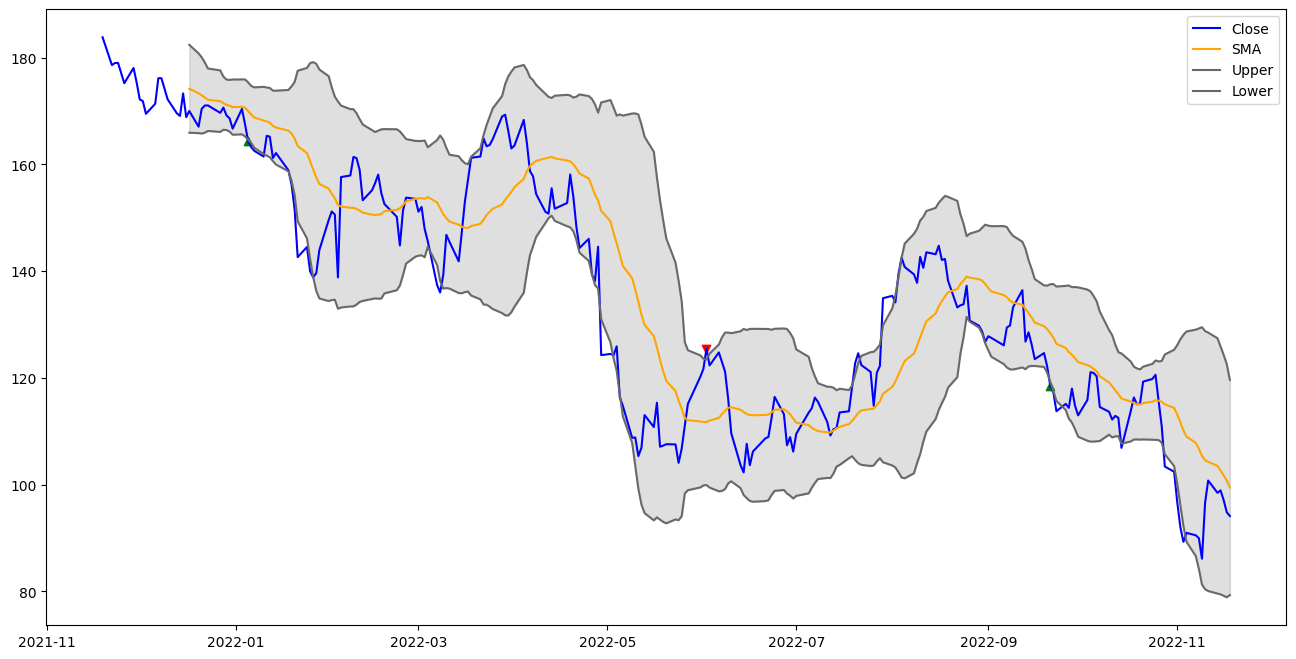

In [205]:
fig, ax = plt.subplots(figsize=(16, 8))
colors = ["blue", "orange", "dimgray", "dimgray"]
ax.set_prop_cycle("color", colors)
h = ax.plot(
    stock_hist[["Close", "SMA", "Upper", "Lower"]],
)
# Find the buying points when the buying signal is true
ax.scatter(
    stock_hist.iloc[buys].index,
    stock_hist.iloc[buys]["Close"],
    marker="^",
    color="g",
)
ax.scatter(
    stock_hist.iloc[sells].index,
    stock_hist.iloc[sells]["Close"],
    marker="v",
    color="r",
)
ax.fill_between(
    stock_hist.index, stock_hist["Upper"], stock_hist["Lower"], color="grey", alpha=0.25
)
# for line, color in zip(h, colors):
#     line.set_color(color)
ax.legend(["Close", "SMA", "Upper", "Lower"])

## Predictions using Prophet